In [5]:
import torch
import pyro
import numpy as np
from torch import nn
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam
import matplotlib.pyplot as plt
from pyro.infer.autoguide import AutoDelta, AutoGuideList, AutoDiagonalNormal, AutoNormal
from pyro import poutine

In [6]:
# Generate Artificial Samples
z_true = torch.randn(100, 2)
W_true = torch.round(torch.randn(2, 5) * 5)
mu_true = torch.ones(5) * 2
X = z_true @ W_true + mu_true + torch.randn(100, 5) * 0.5

In [7]:
W_true

tensor([[ 5., -6., -1.,  5., -2.],
        [ 2., -1., -5., -1., -2.]])

## Model 1

PPCA, without prior over $W$

In [47]:

class PCA_1(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim
        
    def model(self, x):
        n = x.size(0)
        obs_dim = x.size(1)
        
        w = pyro.param("w", torch.randn(self.latent_dim, obs_dim))
        mu = pyro.param("mu", torch.rand(obs_dim))
        sigma = pyro.param("sigma", torch.ones(1), constraint=pyro.distributions.constraints.positive)
        
        with pyro.plate("data_size_z", n):
            z = pyro.sample("Z", dist.Normal(0, 1).expand([n, self.latent_dim]).to_event(1))
            pyro.sample("X", dist.MultivariateNormal(z @ w + mu, torch.eye(obs_dim) * sigma), obs=x)
            
            

In [48]:
pyro.clear_param_store()
pca = PCA_1()
opt = Adam({"lr": 0.01})

guide = AutoGuideList(pca.model)
guide.append(AutoNormal(poutine.block(pca.model, hide=[])))
svi = SVI(pca.model, guide, optim=opt, loss=Trace_ELBO())

In [49]:
ELBO = []
for i in range(3000):
    elbo = svi.step(X)
    ELBO.append(-elbo)

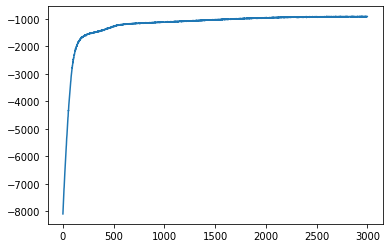

In [50]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBO)

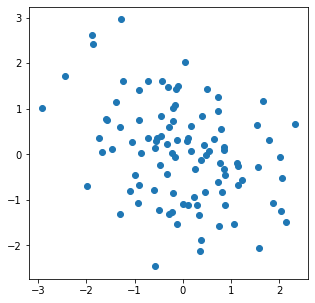

In [51]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.scatter(guide.median()["Z"][:, 0].detach().numpy(), guide.median()["Z"][:, 1].detach().numpy())

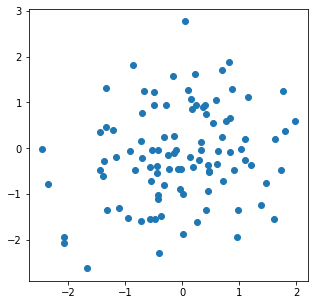

In [52]:
plt.scatter(z_true[:, 0].detach().numpy(), z_true[:, 1].detach().numpy())

## Model 2

Bayesian PPCA, with ARD prior over $W$

In [53]:
class PCA_2(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.latent_dim = latent_dim
        
    def model(self, x):
        n = x.size(0)
        obs_dim = x.size(1)
        
        a = pyro.param("a", torch.ones([self.latent_dim, 1]), constraint=pyro.distributions.constraints.positive)
        mu = pyro.param("mu", torch.rand(obs_dim))
        sigma = pyro.param("sigma", torch.ones(1), constraint=pyro.distributions.constraints.positive)
        
        with pyro.plate("latent_dim", self.latent_dim):
            W = pyro.sample("W", dist.Normal(0, a.expand([self.latent_dim, obs_dim]) ** -1).to_event(1))
        with pyro.plate("data_size_z", n):
            z = pyro.sample("Z", dist.Normal(0, 1).expand([self.latent_dim]).to_event(1))
            pyro.sample("X", dist.MultivariateNormal(z @ W + mu, torch.eye(obs_dim) * sigma), obs=x)

In [54]:
pyro.clear_param_store()
pca = PCA_2()

opt = Adam({"lr": 0.01})

guide = AutoGuideList(pca.model)
guide.append(AutoNormal(poutine.block(pca.model, hide=[])))#, hide=["W"])))
#guide.state_dict()["0.locs.W_unconstrained"] = nn.Parameter(torch.cat([W_true, torch.zeros(2, 5)]).detach())

#guide.append(AutoDelta(poutine.block(pca.model, expose=["W"])))

svi = SVI(pca.model, guide, optim=opt, loss=Trace_ELBO())

In [55]:
ELBO = []
for i in range(4000):
    elbo = svi.step(X)
    ELBO.append(-elbo)

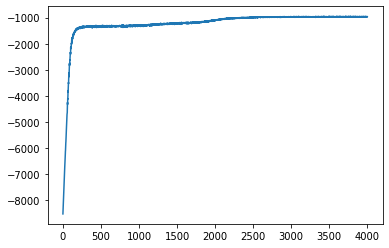

In [56]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBO)

In [57]:
pyro.param("a")

tensor([[37.1849],
        [ 0.2590],
        [33.1833],
        [ 0.4159]], grad_fn=<AddBackward0>)

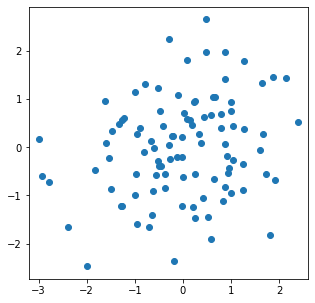

In [60]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.axis('equal')
plt.scatter(guide.median()["Z"][:, 1].detach().numpy(), guide.median()["Z"][:, 3].detach().numpy())

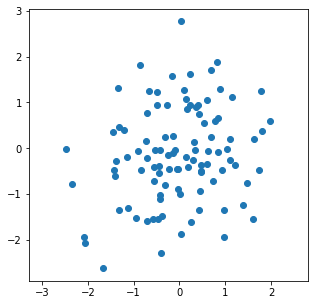

In [61]:
plt.axis('equal')
plt.scatter(z_true[:, 0].detach().numpy(), z_true[:, 1].detach().numpy())

## Model 3
Set ARD prior to $Z$ and constrain $W$ by a fixed prior


In [68]:
class PCA_3(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=5, n=100):
        super().__init__()

        self.latent_dim = latent_dim

        
    def model(self, x):
        n = x.size(0)
        obs_dim = x.size(1)
        
        b = pyro.param("b", torch.ones(1), constraint=pyro.distributions.constraints.positive)
        a = pyro.param("a", torch.rand(self.latent_dim), constraint=pyro.distributions.constraints.positive)
        mu = pyro.param("mu", torch.rand(obs_dim))
        sigma = pyro.param("sigma", torch.ones(1), constraint=pyro.distributions.constraints.positive)

        with pyro.plate("latent_dim", self.latent_dim):
            W = pyro.sample("W", dist.Normal(0, b * torch.ones(obs_dim)).to_event(1))
        with pyro.plate("data_size_z", n):
            z = pyro.sample("Z", dist.Normal(0, a ** -1).expand([n, self.latent_dim]).to_event(1))
            pyro.sample("X", dist.MultivariateNormal(z @ W + mu, torch.eye(obs_dim) * sigma), obs=x)

In [69]:
pyro.clear_param_store()
pca = PCA_3()


opt = Adam({"lr": 0.01})

guide = AutoGuideList(pca.model)
guide.append(AutoNormal(poutine.block(pca.model, hide=[])))#, hide=["W"])))
#guide.state_dict()["0.locs.W_unconstrained"] = nn.Parameter(torch.cat([W_true, torch.zeros(2, 5)]).detach())

#guide.append(AutoDelta(poutine.block(pca.model, expose=["W"])))

svi = SVI(pca.model, guide, optim=opt, loss=Trace_ELBO())

In [70]:
ELBO = []
for i in range(7000):
    elbo = svi.step(X)
    ELBO.append(-elbo)

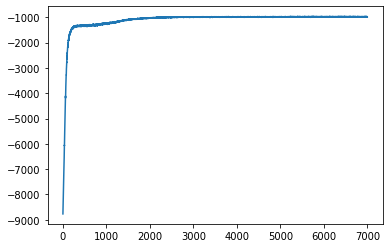

In [71]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBO)

In [72]:
pyro.param("a")

tensor([4.2182, 0.5842, 0.4665, 5.6843], grad_fn=<AddBackward0>)

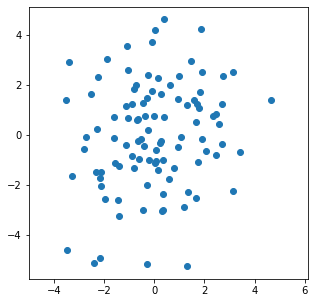

In [73]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.axis('equal')
plt.scatter(guide.median()["Z"][:, 1].detach().numpy(), guide.median()["Z"][:, 2].detach().numpy())

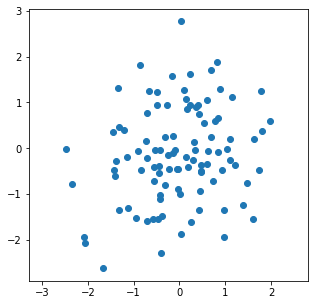

In [74]:
plt.axis('equal')
plt.scatter(z_true[:, 0].detach().numpy(), z_true[:, 1].detach().numpy())